In [103]:
# Add root folder to python path
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))

# Add some common packages
import numpy as np
import pandas as pd
import math
import scipy.stats as ss
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm import tqdm

import plotly.express as px
from reliability.Fitters import Fit_Weibull_3P

In [104]:
# Set up the failure mode class
from pof.failure_mode import FailureMode
from pof.condition import Condition
from pof.task import *

fm = FailureMode(alpha=50, beta=1.5, gamma=20)

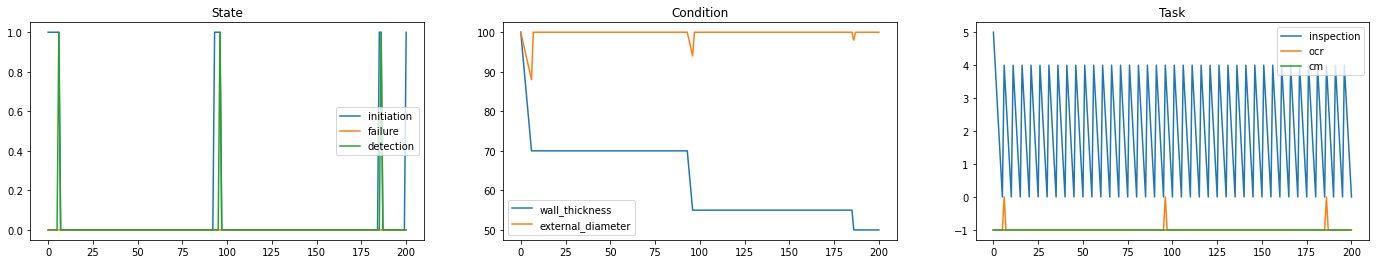

In [116]:
timeline = fm.sim_timeline(200, verbose=False)
fm.plot_timeline()

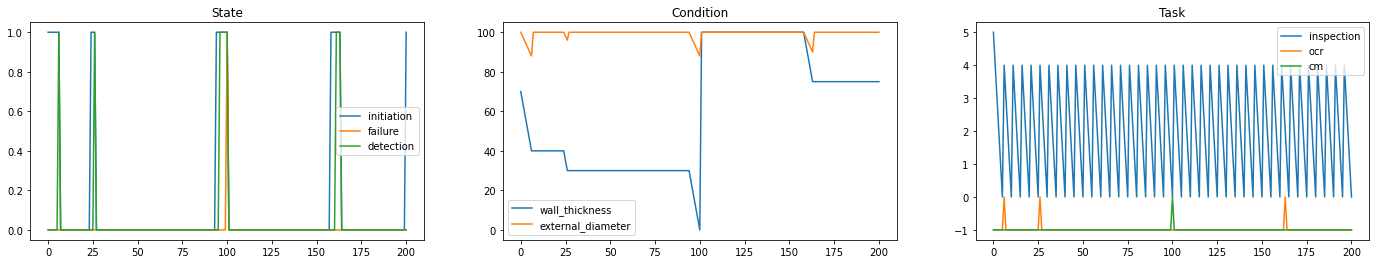

In [117]:
fm._initiated = True
fm.conditions['wall_thickness'].set_condition(70)
#fm.conditions['wall_thickness'].set_condition_profile()
fm.sim_timeline(200)
fm.plot_timeline()

In [130]:
fm = FailureMode(alpha=50, beta=1.5, gamma=20)

fm.conditions['wall_thickness'] = Condition(100, 0, 'linear', [-5])
fm.tasks['inspection'].p_effective = 1
fm.mc_timeline(t_end=200, n_iterations=1000)

df = fm.expected_cost_df()

fig = px.area(df, x="time", y="cost", color="task", title='Maintenance Strategy Costs')
fig.show()

100%|██████████| 1000/1000 [00:07<00:00, 135.60it/s]


In [131]:
fig = px.area(df, x="time", y="cost_cumulative", color="task", title='Maintenance Strategy Costs')
fig.show()

Results from Fit_Weibull_3P (95% CI):
           Point Estimate  Standard Error    Lower CI    Upper CI
Parameter                                                        
Alpha          217.533352        7.659961  203.026465  233.076802
Beta             4.179232        0.309531    3.614539    4.832145
Gamma           53.572695       27.025045   19.931965  143.991505
Log-Likelihood: -1219.475333112236


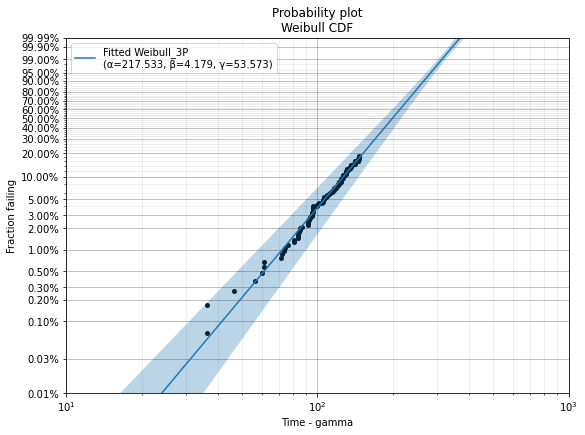

In [140]:
t_failures = []
for timeline in fm._timelines.values():
    t_failures = np.append(t_failures, np.argmax(timeline['failure']))

# Arange into failures and censored data
failures = t_failures[t_failures > 0]
censored = np.full(sum(t_failures==0), 200)

# Fit the Weibull
Fit_Weibull_3P(failures=failures, right_censored=censored)

Text(0.5, 1.0, 'failures')

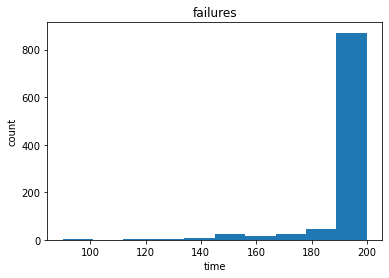

In [150]:
plt.hist(np.append(failures, censored))
plt.xlabel('time')
plt.ylabel('count')
plt.title('failures')

In [8]:
n_iterations = 1000
t_end = 200
t_start = 0

fm2 = FailureMode(alpha=50, beta=1.5, gamma=20)
del fm2.tasks['ocr']

for i in tqdm(range(n_iterations)):

    fm2._timelines[i] = fm2.sim_timeline(t_end=t_end, t_start=t_start)

100%|██████████| 1000/1000 [00:08<00:00, 123.73it/s]


Results from Fit_Weibull_3P (95% CI):
           Point Estimate  Standard Error   Lower CI   Upper CI
Parameter                                                      
Alpha           49.011679        1.111749  46.880418  51.239831
Beta             1.465928        0.036586   1.395946   1.539418
Gamma           24.633758        0.338337  23.979475  25.305893
Log-Likelihood: -4692.398402851915


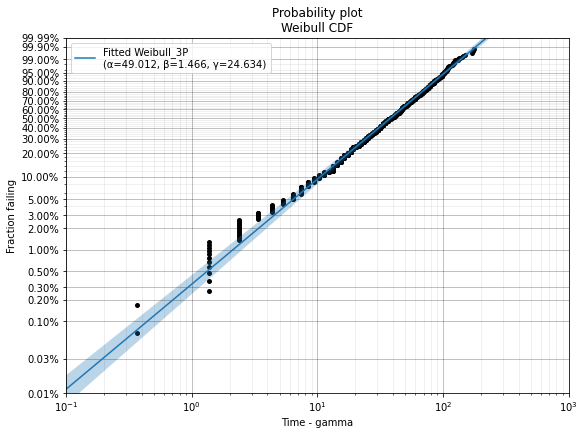

In [9]:
t_failures = []
for timeline in fm2._timelines.values():
    t_failures = np.append(t_failures, np.argmax(timeline['failure']))

# Arange into failures and censored data
failures = t_failures[t_failures > 0]
censored = np.full(sum(t_failures==0), 200)

# Fit the Weibull
Fit_Weibull_3P(failures=failures, right_censored=censored)

In [10]:
df2 = fm.mc_risk_df()

In [11]:
t_interval = dict()
risk = dict()
cost = dict()
fm.reset()

for i in range(1,10, 1):

    # Set t_interval
    fm.tasks['inspection'].t_interval = i
    
    fm.mc_timeline(t_end=100, n_iterations=1000)

    cost[i] = fm.expected_costs()
    cost[i]['inspection_interval'] = i

    # Reset fm

    fm.reset()

100%|██████████| 1000/1000 [00:03<00:00, 326.31it/s]


In [13]:
df_plot = pd.DataFrame(cost).T

df_plot = pd.melt(df_plot, id_vars=['inspection_interval'], var_name = 'source', value_name = 'cost')

fig = px.line(df_plot, x="inspection_interval", y="cost", color='source', title='Risk v Cost at different Inspection Intervals')
fig.show()

In [156]:
# Dists


# Tasks
scheduled_inspection = Inspection(t_interval=10)

scheduled_inspection.set_params(
        t_interval = 5,
        t_delay = 20,
        p_effective = 0.9,
        state_triggers = dict(),

        condition_triggers = dict(
            wall_thickness = dict(
                lower = 0,
                upper = 90,
            ),
        ),

        state_impacts = dict( 
            detection = True,
        ),

        condition_impacts = dict(
            wall_thickness = dict(
                target = None,
                reduction_factor = 0,
                method = 'reduction_factor',
                axis = 'condition',
             ),
        ),
)



# Failure Modes
early_life = FailureMode(alpha=10000, beta=0.5, gamma=0)
random = FailureMode(alpha=100, beta=1, gamma=0)
slow_aging = FailureMode(alpha=100, beta=1.5, gamma=20)
fast_aging = FailureMode(alpha=50, beta=3, gamma=20)

fm_demo = slow_aging

fm_demo.set_conditions(dict(
    wall_thickness = Condition(100, 0, 'linear', [-2]),
    external_diameter = Condition(100, 0, 'linear', [-5]),
))

fm_demo.set_tasks(dict(
    inspection = scheduled_inspection,
    #ocr = OnConditionRepair(activity='on_condition_repair').set_default(),
    cm = ImmediateMaintenance(activity='cm').set_default(),
))


True

In [158]:
scheduled_inspection.__dict__

{'activity': 'inspection',
 'trigger': 'time',
 'trigger_comp': '1.1.2',
 '_package': NotImplemented,
 '_impacts_parent': NotImplemented,
 '_impacts_children': False,
 'cost': 100,
 'labour': 'trade',
 'spares': 'pole',
 'equipment': 'ewp',
 'consequence': <pof.consequence.Consequence at 0x27c43320880>,
 'p_effective': 0.9,
 'time_triggers': {},
 'state_triggers': {},
 'condition_triggers': {},
 'time_imapcts': {},
 'state_impacts': {},
 'condition_impacts': {},
 'state': 'up',
 't_completion': [],
 '_timeline': NotImplemented,
 '_count_checked': NotImplemented,
 '_count_triggered': NotImplemented,
 '_count_completed': 0,
 't_delay': 20,
 't_interval': 5}

In [152]:
fm_demo.mc_timeline(1000)

df = fm_demo.expected_cost_df()

fig = px.area(df, x="time", y="cost_cumulative", color="task", title='Maintenance Strategy Costs')
fig.show()

100%|██████████| 100/100 [00:06<00:00, 16.34it/s]


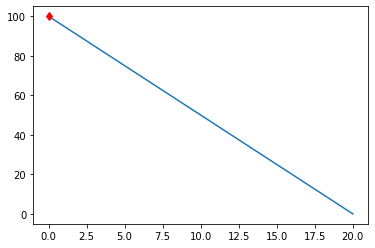

In [155]:
fm.conditions['wall_thickness'].plot_condition_profile()
